In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd

from numpy import dot, array, zeros, linspace, mod, sqrt, mean, std, exp, sin, cos, pi, imag, real, angle, mod
from numpy.linalg import norm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'size'   : 12}
mpl.rc('font', **font)

In [23]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
#path = '/home/surov/Library/navec_news_v1_1B_250K_300d_100q.tar'
model = Navec.load(path)

In [24]:
dt = pd.read_csv('data_6x2891.csv', index_col=0)
dt

,род,пред,вин,им,дат,твор
0,абзаца,абзаце,абзац,абзац,абзацу,абзацем
1,аборта,аборте,аборт,аборт,аборту,абортом
2,абсурда,абсурде,абсурд,абсурд,абсурду,абсурдом
3,авангарда,авангарде,авангард,авангард,авангарду,авангардом
4,аварии,аварии,аварию,авария,аварии,аварией
...,...,...,...,...,...,...
2886,японца,японце,японца,японец,японцу,японцем
2887,яркости,яркости,яркость,яркость,яркости,яркостью
2888,ярости,ярости,ярость,ярость,ярости,яростью
2889,ясности,ясности,ясность,ясность,ясности,ясностью


In [25]:
# Форматирую данные для функций sklearn. N = число использованных строк датафрейма
# LabelEncoding. Целевая величина y=0 для родительного, 1 для предложного, 2 для винительного и т.д.
N = 1000;
N = len(dt)
x, y = [], []
for n in range(N):
    for k in range(6):
        x.append(model[dt.iloc[n][k]])
        y.append(k)

x = np.array(x)
y = np.array(y)

x.shape, y.shape

((17346, 300), (17346,))

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2024, test_size=0.25)
y_train

array([1, 2, 1, ..., 1, 0, 4])

# К ближайших соседей

In [37]:
f1list = []
for k in range(10,500,20):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(x_train, y_train)
    y_preds_knn = knn.predict(x_test)
    f1 = classification_report(y_test, y_preds_knn, output_dict=True)['weighted avg']['f1-score']
    f1list.append([k,f1])
f1list = array(f1list)

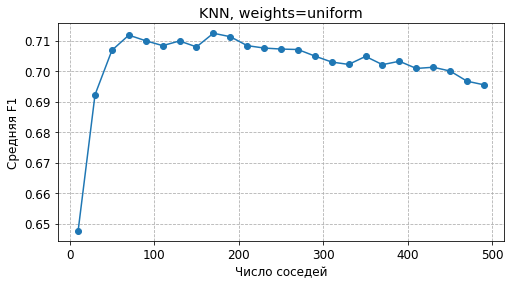

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(f1list[:,0], f1list[:,1], marker='o')
ax.grid(True, ls='--');
ax.set_xlabel('Число соседей')
ax.set_ylabel('Средняя F1');
ax.set_title('KNN, weights=uniform');

In [41]:
f1list = []
for k in range(10,500,20):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(x_train, y_train)
    y_preds_knn = knn.predict(x_test)
    f1 = classification_report(y_test, y_preds_knn, output_dict=True)['weighted avg']['f1-score']
    f1list.append([k,f1])
f1list = array(f1list)

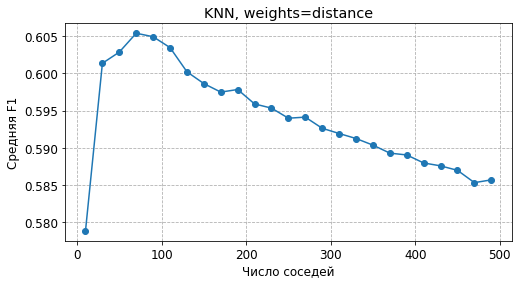

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(f1list[:,0], f1list[:,1], marker='o')
ax.grid(True, ls='--');
ax.set_xlabel('Число соседей')
ax.set_ylabel('Средняя F1');
ax.set_title('KNN, weights=distance');

## <font color='red'>Вывод</font>
Наилучшая точность при weights=uniform с числом соседей примерно 50-200. При этом средняя F1 = 71%

In [52]:
# Оптимальное решение
knn = KNeighborsClassifier(n_neighbors=70, weights='uniform', algorithm='brute')
knn.fit(x_train, y_train)

y_preds_knn = knn.predict(x_test)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.62      0.89      0.73       705
           1       0.85      0.78      0.82       725
           2       0.44      0.36      0.39       736
           3       0.53      0.52      0.52       740
           4       0.89      0.80      0.84       732
           5       0.99      0.96      0.98       699

    accuracy                           0.72      4337
   macro avg       0.72      0.72      0.71      4337
weighted avg       0.72      0.72      0.71      4337



In [49]:
conmat = confusion_matrix(y_test, y_preds_knn)
conmat

array([[629,  25,  35,   5,  11,   0],
       [125, 568,  13,   7,  11,   1],
       [110,  19, 263, 322,  22,   0],
       [ 34,  23, 276, 383,  21,   3],
       [104,  25,   9,   6, 588,   0],
       [  6,   5,   4,   6,   7, 671]])

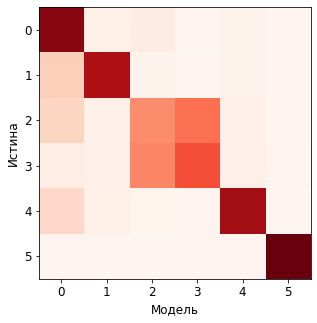

In [50]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(conmat, cmap='Reds', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

## <font color='red'>Вывод</font>
Крайние классы определяются лучше чем средние. Вот отсюда возникло ощущение что значения Y обладают метрикой

# Масштабирование

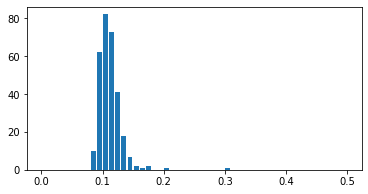

In [36]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(x.var(axis=0), bins=50, rwidth=0.8, range=[0,0.5]);

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

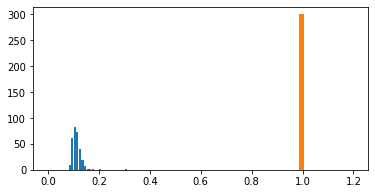

In [37]:
ax.hist(x_train_scaled.var(axis=0), bins=50, rwidth=0.8, range=[0,1.2]);
fig

In [31]:
knn = KNeighborsClassifier(n_neighbors=70, weights='uniform')
knn.fit(x_train_scaled, y_train)

y_preds_knn = knn.predict(x_test_scaled)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74       705
           1       0.84      0.79      0.81       725
           2       0.45      0.36      0.40       736
           3       0.53      0.51      0.52       740
           4       0.88      0.81      0.84       732
           5       0.99      0.96      0.97       699

    accuracy                           0.72      4337
   macro avg       0.72      0.72      0.71      4337
weighted avg       0.72      0.72      0.71      4337



## <font color='red'>Вывод</font>
Масштабирование выигрыша не даёт. Кроме того, оно искажает пространство word2vec что скорее всего нежелательно

# КNN в пониженной размерности

In [50]:
# По аналогии с примером 
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html

### Снижение размерности методом NeighborhoodComponentsAnalysis

In [38]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

In [114]:
# Нахождение наилучшей плоскости для различения классов
nca = NeighborhoodComponentsAnalysis(n_components=3, n_jobs=-1);
nca.fit(x_train, y_train)

NeighborhoodComponentsAnalysis(n_components=3)

In [116]:
# Сохраняю т.к. считается минут 5
import pickle
with open('nca_dim3.pkl', 'wb') as file:
    pickle.dump(nca, file)
    
'''with open('nca.pkl', 'rb') as file:
    nca = pickle.load(file)''';

In [117]:
# Применение KNN к трансформированным данным

knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(nca.transform(x_train), y_train)

y_preds_knn = knn.predict(nca.transform(x_test))

In [118]:
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       705
           1       0.87      0.78      0.83       725
           2       0.42      0.43      0.42       736
           3       0.50      0.47      0.49       740
           4       0.88      0.82      0.85       732
           5       0.98      0.97      0.98       699

    accuracy                           0.71      4337
   macro avg       0.72      0.71      0.71      4337
weighted avg       0.72      0.71      0.71      4337



In [119]:
xdim3 = nca.transform(x)

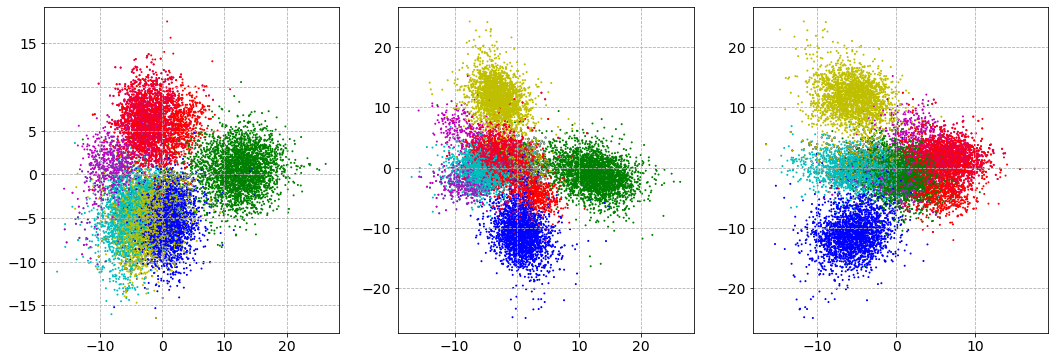

In [122]:
# Окраска классов в порядке столбцов датафрейма
cmap = mpl.colors.ListedColormap(['c','b','m','r','y','g'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6], 6)

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(xdim3[:, 0], xdim3[:, 1], c=y, s=1, cmap=cmap, norm=norm);
ax[1].scatter(xdim3[:, 0], xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);
ax[2].scatter(xdim3[:, 1], xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);

for a in ax: 
    a.grid(True, ls='--')

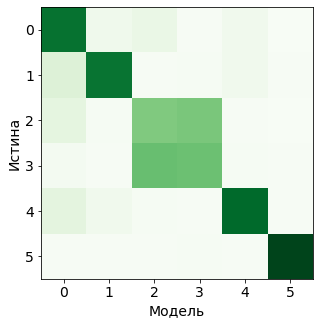

In [123]:
conmat = confusion_matrix(y_test, y_preds_knn)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

### Снижение размерности методом LinearDiscriminantAnalysis

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [54]:
# Нахождение наилучшей плоскости для различения классов
lda = LinearDiscriminantAnalysis(n_components=3);
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=3)

In [55]:
# Применение KNN к двумерным данным

knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(lda.transform(x_train), y_train)

y_preds_knn = knn.predict(lda.transform(x_test))

In [56]:
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.56      0.85      0.67       705
           1       0.95      0.75      0.84       725
           2       0.37      0.22      0.28       736
           3       0.50      0.62      0.55       740
           4       0.93      0.81      0.87       732
           5       0.99      0.98      0.98       699

    accuracy                           0.70      4337
   macro avg       0.72      0.71      0.70      4337
weighted avg       0.71      0.70      0.70      4337



In [57]:
xdim3 = lda.transform(x)
xdim3.shape, y.shape

((17346, 3), (17346,))

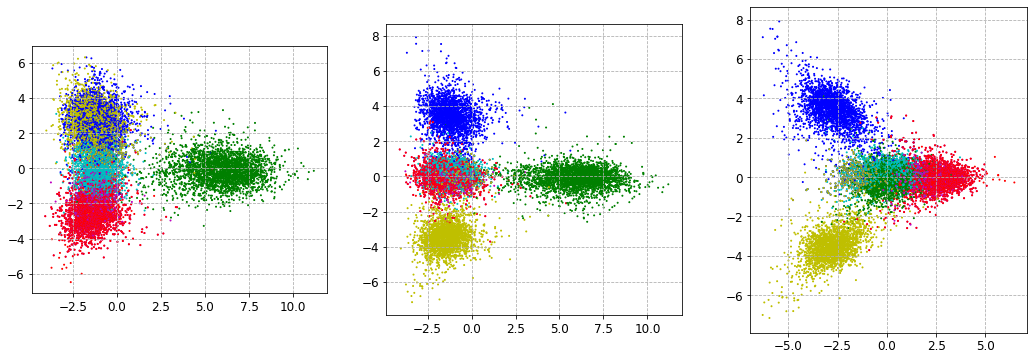

In [58]:
# Окраска классов в порядке столбцов датафрейма.
cmap = mpl.colors.ListedColormap(['c','b','m','r','y','g'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6], 6)

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(xdim3[:, 0], -xdim3[:, 1], c=y, s=1, cmap=cmap, norm=norm);
ax[1].scatter(xdim3[:, 0], -xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);
ax[2].scatter(xdim3[:, 1], -xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);

for a in ax: 
    a.grid(True, ls='--')
    a.set_aspect(1)

In [59]:
conmat = confusion_matrix(y_test, y_preds_knn)
conmat

array([[600,   9,  53,  24,  19,   0],
       [157, 545,   5,   3,  14,   1],
       [132,   5, 161, 433,   4,   1],
       [ 58,   5, 207, 461,   5,   4],
       [124,   7,   5,   2, 590,   4],
       [  8,   1,   2,   2,   0, 686]])

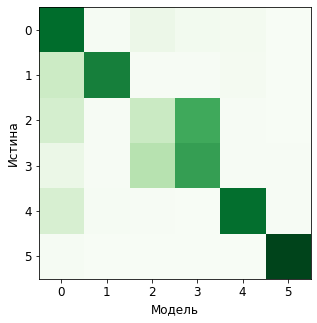

In [60]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [62]:
# Дополнительная отрисовка

dtp = pd.DataFrame(data=xdim3, columns=['d1','d2','d3'])
dtp['y'] = y

# Без винительного (фиотеловый)
dtp_no2 = dtp[dtp['y'] != 2]
# Без винительного и творительного (фиотеловый и зелёный)
dtp_no25 = dtp[(dtp['y'] != 2) & (dtp['y'] != 5)]

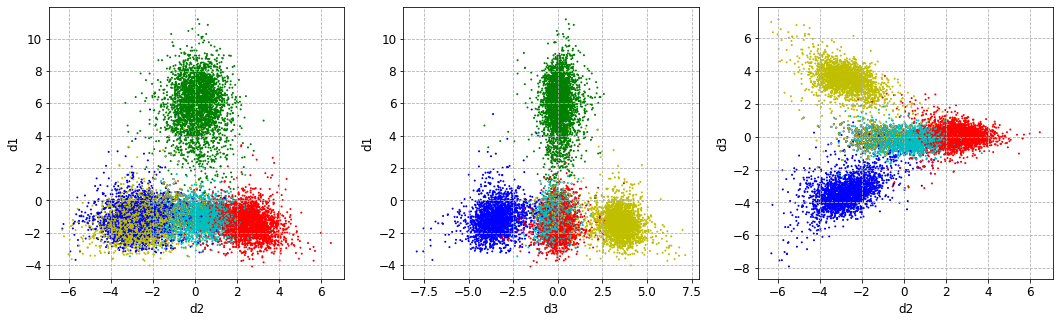

In [63]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

ax[0].scatter(dtp_no2['d2'], dtp_no2['d1'], c=dtp_no2['y'], s=1, cmap=cmap, norm=norm);
ax[0].set_xlabel('d2')
ax[0].set_ylabel('d1')

ax[1].scatter(dtp_no2['d3'], dtp_no2['d1'], c=dtp_no2['y'], s=1, cmap=cmap, norm=norm);
ax[1].set_xlabel('d3')
ax[1].set_ylabel('d1')

ax[2].scatter(dtp_no25['d2'], dtp_no25['d3'], c=dtp_no25['y'], s=1, cmap=cmap, norm=norm);
ax[2].set_xlabel('d2')
ax[2].set_ylabel('d3')

for a in ax: a.grid(True, ls='--')

## <font color='red'>Вывод</font>
Кроме винительного и именительного, в обоих методах классы разделяются хорошо. F1 несильно ниже наилучшей 0.71, следовательно трёх измерений достаточно для различения падежей в 300-мерном word2vec.

Второй метод выявил геометрическую структуру. Творительный падеж (зелёный) уникален по первой оси d1, остальные лежат в лоскости d2-d3. В этой плоскости предложный (синий), именительный (красный) и дательный (жёлтый) лежат в вершинах треугольника, а родительный (голубой) близко к его центру.

## KNN c OneHotEncoding (проблема)

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
dt = pd.read_csv('data_1x17346.csv', index_col=0)
dt

,word,pad
0,абзаца,R
1,абзаце,P
2,абзац,V
3,абзац,I
4,абзацу,D
...,...,...
17341,ящике,P
17342,ящик,V
17343,ящик,I
17344,ящику,D


In [10]:
ohe = OneHotEncoder()
res = ohe.fit_transform(dt['pad'].to_numpy().reshape(-1, 1))

Y_df = pd.DataFrame(res.toarray(), columns=ohe.get_feature_names_out())
Y_df

,x0_D,x0_I,x0_P,x0_R,x0_T,x0_V
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
17341,0.0,0.0,1.0,0.0,0.0,0.0
17342,0.0,0.0,0.0,0.0,0.0,1.0
17343,0.0,1.0,0.0,0.0,0.0,0.0
17344,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
Y = pd.get_dummies(dt['pad'], prefix='pad')
Y

,pad_D,pad_I,pad_P,pad_R,pad_T,pad_V
0,0,0,0,1,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,1,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
17341,0,0,1,0,0,0
17342,0,0,0,0,0,1
17343,0,1,0,0,0,0
17344,1,0,0,0,0,0


In [13]:
X = array([model[w] for w in dt['word']])
X.shape

(17346, 300)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=2024, test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13009, 300), (13009, 6), (4337, 300), (4337, 6))

In [21]:
knn = KNeighborsClassifier(n_neighbors=70, weights='distance')
knn.fit(x_train, y_train)

y_preds_knn = knn.predict(x_test)
y_preds_knn

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [22]:
# Непонятно почему есть нулевые строки, т.е. предсказания нет? Таких много:
len(x_test) - np.sum(y_preds_knn)

1271.0

In [ ]:
# Всё что нашёл на эту тему малосодержательно
# https://stackoverflow.com/questions/66517143/why-does-my-kneighborsclassifier-return-some-empty-predictions